In [44]:
%matplotlib inline

import sys
import numpy as np
import scipy as sp
import sympy as sym
import numexpr as ne
import matplotlib.pyplot as plt

#import of acalib helper functions
sys.path.append('../../ACALIB/')
from acalib import acontainer as ac

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}} L(x, u, u_x) \ dx  = \int_{\Omega \subset \mathbb{R}}(u(x)-f_0(x))^2 + \alpha \ \Psi_1(u(x)-f_0(x)) + \beta \ \Psi_2(|u'(x)|) \ dx $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} =  2(u(x)-f_0(x)) + \alpha \ \Psi_1'(u(x)-f_0(x)) - \beta \ u_{xx}(x) \ \Psi_2''(|u_{x}(x)|)$$

the proposed solution has the form of a linear combination of Gaussian functions:

$$u(x) = \sum_{i=1}^N c_i \ \phi(x; x_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2}{2 \sigma_i^2}}$$

In [30]:
"""
Loading data
"""
cont = ac.AContainer()
#cont.load('../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits')
cont.load('../../bindata/fits/cubes/M100line.image.fits')
#cont.load('../../bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits')

cube = cont.primary
spar = cube.standarize()
data = cube.data

INFO: Processing HDU 0 (Image) [acalib.io.formats]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.formats]


In [45]:
"""
Generating the data function
"""
f_data = data[:,300,300]
x = np.linspace(0., 1., len(f_data), endpoint=True)
f = sp.interpolate.interp1d(x, f_data, kind='quadratic')

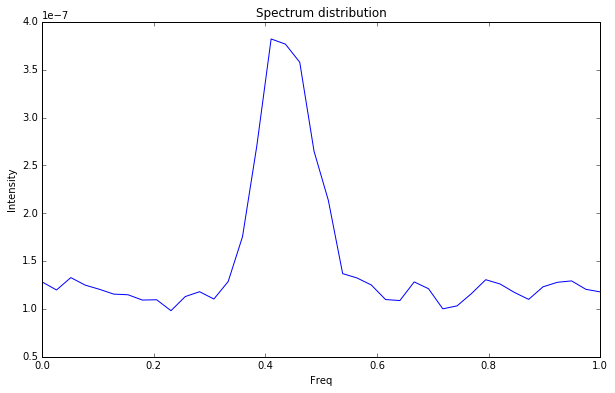

In [51]:
plt.figure(figsize=(10,6))
plt.plot(x, f_data, '-')
plt.title('Spectrum distribution')
plt.xlabel('Freq')
plt.ylabel('Intensity')
plt.show()

In [52]:
#setting parameters
a = 0.01
b = 1.
N = 20

z = sym.Symbol('z')

#Penalizing function and its derivatives
psi1 = sym.exp(z)
d1psi1 = sym.diff(psi1, z)
d1psi1 = sym.lambdify(z, d1psi1, modules='numpy')

#Smoothing function and its derivatives
lamb = 0.5
psi2 = 2*lamb*sym.log(1 + z**2/lamb)
d1psi2 = sym.diff(psi2, z)
d2psi2 = sym.diff(d1psi2, z)
d1psi2 = sym.lambdify(z, d1psi2, modules='numpy')
d2psi2 = sym.lambdify(z, d2psi2, modules='numpy')

In [53]:
"""
RBF (Gaussian) functions and its derivatives
"""
def phi(x, sig):
    retval = ne.evaluate('exp(-x**2/(2*sig**2))')
    return retval

def phix(x, sig):
    retval = ne.evaluate('-(1./sig**2) * exp(-x**2/(2*sig**2)) * x')
    return retval

def phixx(x, sig):
    retval = ne.evaluate('(1./sig**4) * exp(-x**2/(2*sig**2)) * (x**2 - sig**2)')
    return retval

In [54]:
""" Computing collocation points """
xc = np.linspace(0., 1., N+1)[1::]-(1./(2.*N))

""" Computing evaluation points """
xe = np.linspace(0., 1., 2*N, endpoint=True)

""" Computing the values of f at evaluation points """
f0 = f(xe)

""" 
Computing distance matrix.
Note: Evaluation and collocation point will be the same
"""
Dx = np.empty((2*N,N))
for k in range(2*N):
	Dx[k,:] = (xe[k] - xc)

In [63]:
def F(X):
    #unpacking parameters
    N = len(X)/2
    c = X[0:N]
    sig = X[N:]
    
    #phi function's evaluation
    phi_m   = phi(Dx, sig)
    phix_m  = phix(Dx, sig)
    phixx_m = phixx(Dx, sig)
    
    #computing the Euler-Lagrange equation
    u   = np.dot(phi_m, c)
    ux  = np.dot(phix_m, c)
    uxx = np.dot(phixx_m, c)
    return 2*(u-f0) + a*d1psi1(u-f0) - b*uxx*d2psi2(np.abs(ux))


In [69]:
"""
Defining initial parameter values
"""
c0 = np.min(f_data)*np.ones(N)
sig0 = (1./(6*N))*np.ones(N) #see the note
X0 = np.concatenate([c0,sig0])

__Note:__ $6 \sigma \cdot N = b-a \rightarrow \sigma = \frac{b-a}{6*N}$

In [87]:
"""
Solve it!
"""
X = sp.optimize.fsolve(F, X0)
c = X[0:N]
sig = X[N:]
print("c coeficients:"); print(c)
print('sigmas:'); print(sig)

c coeficients:
[ -1.77000260e-06  -1.39095243e-06  -1.37042980e-06  -1.25279935e-06
  -1.12516035e-08  -5.72256682e-05   5.59725407e-07   3.97197454e-07
   2.50317279e-07   2.47787863e-07   2.48276116e-07   2.73279451e-07
   4.45164391e-07   4.71920100e-07  -2.24559270e-06   3.62786831e-07
  -4.92083126e-08  -6.29659938e-06  -7.26040069e-06  -5.36981844e-06]
sigmas:
[ 0.26800446  0.14339741  0.1103132  -0.07388839 -3.64693012  0.96566855
  0.00689499  0.00714678  0.00615808  0.00597168  0.00600343  0.00654088
  0.00717785  0.00652589 -0.04436632 -3.82499089 -0.61006481  0.30559781
  0.17656558  0.66401981]


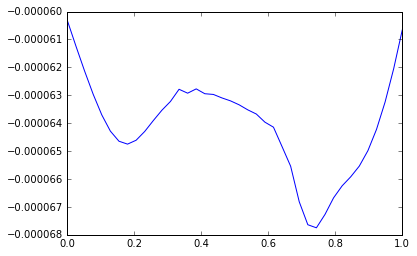

In [92]:
"""
Visualizing the result
"""
phi_m = phi(Dx, sig)
u = np.dot(phi_m, c)
plt.plot(xe, u)
plt.show()